In [1]:
import os
import sys
import tensorflow as tf
import numpy as np
import json

sys.path.append('ibmHearingAid/multi_gpu')
import pitchnet_evaluate_best
import functions_graph_assembly as fga

sys.path.append('/om4/group/mcdermott/user/msaddler/pitchnet_dataset/pitchnetDataset/pitchnetDataset')
import dataset_util

sys.path.append('assets_psychophysics')
import util_psychophysics_figures

import importlib
%matplotlib inline
import matplotlib.pyplot as plt

ImportError in `dataset_util.py` No module named 'pyfftw'


In [15]:
output_directory = '/saved_models/arch_0628/PND_v04_TLAS_classification1'
# output_directory = '/saved_models/arch_0628/PND_v04_JWSS_highpass_v00_classification2'

config_fn = os.path.join(output_directory, 'config.json')
validation_metrics_fn = os.path.join(output_directory, 'validation_metrics.json')

tfrecords_regex = '/om/user/msaddler/data_pitchnet/bernox2005/FixedFilter_f0min100_f0max300/cf100_species002_spont070/*.tfrecords'

with open(config_fn) as f: CONFIG = json.load(f)

ckpt_num = pitchnet_evaluate_best.get_best_checkpoint_number(validation_metrics_fn,
                                                             metric_key='f0_label:accuracy',
                                                             maximize=True,
                                                             checkpoint_number_key='step')


Selecting checkpoint 64000 (f0_label:accuracy=0.21008743345737457)


In [16]:
ITERATOR_PARAMS = CONFIG['ITERATOR_PARAMS']
batch_size = 128
bytesList_decoding_dict = {"meanrates": {"dtype": "tf.float32", "shape": [100, 500]}}
feature_parsing_dict = pitchnet_evaluate_best.get_feature_parsing_dict_from_tfrecords(tfrecords_regex,
                                                                                      bytesList_decoding_dict)

ITERATOR_PARAMS['feature_parsing_dict'] = feature_parsing_dict
N_CLASSES_DICT = CONFIG['N_CLASSES_DICT']
BRAIN_PARAMS = CONFIG['BRAIN_PARAMS']


tf.reset_default_graph()

# BUILD TFRECORDS ITERATOR GRAPH
iterator, dataset, _ = fga.build_tfrecords_iterator(tfrecords_regex,
                                                    num_epochs=1, shuffle_flag=False,
                                                    batch_size=batch_size,
                                                    iterator_type='one-shot',
                                                    **ITERATOR_PARAMS)
input_tensor_dict = iterator.get_next()

### BUILD BRAIN NETWORK GRAPH
batch_subbands = input_tensor_dict[ITERATOR_PARAMS['feature_signal_path']]
while len(batch_subbands.shape) < 4: batch_subbands = tf.expand_dims(batch_subbands, axis=-1)
batch_out_dict, brain_container = fga.build_brain_graph(batch_subbands, N_CLASSES_DICT, **BRAIN_PARAMS)

### START SESSION AND INITIALIZE GRAPH
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess = tf.Session()
sess.run(init_op)

### BUILD SAVER GRAPH TO LOAD CHECKPOINT
brain_var_scope = 'brain_network'
brain_ckpt_prefix_name = BRAIN_PARAMS.get('save_ckpt_path', 'brain_model.ckpt')
restore_model_path = os.path.join(output_directory, brain_ckpt_prefix_name + '-{}'.format(ckpt_num))
brain_globals = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=brain_var_scope)
brain_locals = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope=brain_var_scope)
brain_variables =  brain_globals + brain_locals
saver_brain_net, out_ckpt_loc_brain_net, brain_net_ckpt = fga.build_saver(
    sess, brain_variables, output_directory,
    restore_model_path=restore_model_path,
    ckpt_prefix_name=brain_ckpt_prefix_name)


f0 dict_keys(['floatList'])
base_f0 dict_keys(['floatList'])
f0_lognormal dict_keys(['floatList'])
phase_mode dict_keys(['int64List'])
f0_label dict_keys(['int64List'])
f0_log2 dict_keys(['floatList'])
meanrates dict_keys(['bytesList'])
max_audible_harm dict_keys(['int64List'])
delta_f0 dict_keys(['floatList'])
signal dict_keys(['bytesList'])
Ignoring tfrecords_key `signal` (not found in bytesList_decoding_dict)
min_audible_harm dict_keys(['int64List'])
low_harm dict_keys(['int64List'])
pin_dBSPL dict_keys(['floatList'])
### Files found: 36
/om/user/msaddler/data_pitchnet/bernox2005/FixedFilter_f0min100_f0max300/cf100_species002_spont070/bez2018meanrates_000000-002016.tfrecords 
...
 /om/user/msaddler/data_pitchnet/bernox2005/FixedFilter_f0min100_f0max300/cf100_species002_spont070/bez2018meanrates_070583-072600.tfrecords
Loading brain network config from /saved_models/arch_0628/PND_v04_TLAS_classification1/brain_arch.json
ADDING OPS TO CHECKPOINTS
[<tf.Tensor 'brain_network/pool_3:0' s

In [17]:
### EVALUATION ROUTINE + STORE ACTIVATIONS
tensors_to_evaluate = {}

metadata_keys = ['f0', 'f0_label', 'low_harm', 'phase_mode']
for key in metadata_keys:
    tensors_to_evaluate[key] = input_tensor_dict[key]

mean_axis = [1, 2]
for key in brain_container.keys():
    if 'relu' in key:
        activations = brain_container[key]
        if len(activations.shape) == 4:
            tensors_to_evaluate[key] = tf.reduce_mean(activations, axis=mean_axis)
        else:
            tensors_to_evaluate[key] = activations

output_dict = {}
for key in tensors_to_evaluate.keys():
    output_dict[key] = []

display_step = 100
batch_count = 0
try:
    while True:
        evaluated_batch = sess.run(tensors_to_evaluate)
        for key in set(output_dict.keys()).intersection(evaluated_batch.keys()):
            key_val = np.array(evaluated_batch[key]).tolist()
            if not isinstance(key_val, list): key_val = [key_val]
            output_dict[key].extend(key_val)
            
        batch_count += 1
        if batch_count % display_step == 0: print(batch_count)
except tf.errors.OutOfRangeError:
    print('End of evaluation dataset reached.')

for key in output_dict.keys():
    output_dict[key] = np.array(output_dict[key])
    print(key, output_dict[key].shape)


100
200
300
400
500
End of evaluation dataset reached.
f0 (72600,)
relu_2 (72600, 256)
relu_fc_intermediate (72600, 256)
relu_5 (72600, 512)
phase_mode (72600,)
low_harm (72600,)
relu_3 (72600, 128)
f0_label (72600,)
relu_0 (72600, 16)
relu_1 (72600, 32)
relu_4 (72600, 256)


In [18]:
mask = output_dict['phase_mode'] == 0
for key in output_dict.keys():
    output_dict[key] = output_dict[key][mask]

sort_idx = np.argsort(output_dict['f0'])
for key in output_dict.keys():
    output_dict[key] = output_dict[key][sort_idx]
    print(key, output_dict[key].shape)


f0 (36300,)
relu_2 (36300, 256)
relu_fc_intermediate (36300, 256)
relu_5 (36300, 512)
phase_mode (36300,)
low_harm (36300,)
relu_3 (36300, 128)
f0_label (36300,)
relu_0 (36300, 16)
relu_1 (36300, 32)
relu_4 (36300, 256)


In [19]:
def compute_tuning_tensor(output_dict,
                          key_act='relu_1',
                          key_x='low_harm',
                          key_y='f0_label_coarse'):
    
    x_unique = np.unique(output_dict[key_x])
    y_unique = np.unique(output_dict[key_y])
    shape = [x_unique.shape[0], y_unique.shape[0], output_dict[key_act].shape[1]]
    dtype = output_dict[key_act].dtype
    tuning_tensor = np.zeros(shape, dtype=dtype)
    tuning_tensor_counts = np.zeros(shape[:-1] + [1], dtype=int)
    
    x_value_indexes = np.digitize(output_dict[key_x], x_unique, right=True)
    y_value_indexes = np.digitize(output_dict[key_y], y_unique, right=True)
    for idx in range(output_dict[key_act].shape[0]):
        x_idx = x_value_indexes[idx]
        y_idx = y_value_indexes[idx]
        act = output_dict[key_act][idx]
        
        tuning_tensor[x_idx, y_idx, :] += act
        tuning_tensor_counts[x_idx, y_idx] += 1
    
    tuning_tensor = tuning_tensor / tuning_tensor_counts
    return tuning_tensor


coarse_f0_bins = dataset_util.get_f0_bins(f0_min=80., f0_max=1e3, binwidth_in_octaves=1/24)
output_dict['f0']
output_dict['f0_label_coarse'] = dataset_util.f0_to_label(output_dict['f0'], coarse_f0_bins)

tuning_tensor = compute_tuning_tensor(output_dict, key_act='relu_5')
print('computed tuning_tensor:', tuning_tensor.shape)

f0_tuning_array = np.mean(tuning_tensor, axis=0)
print('computed f0_tuning_array:', f0_tuning_array.shape)

low_harm_tuning_array = np.mean(tuning_tensor, axis=1)
print('computed low_harm_tuning_array:', low_harm_tuning_array.shape)

sort_idx_f0_tuning = np.argsort(np.argmax(f0_tuning_array, axis=0))
sort_idx_low_harm_tuning = np.argsort(np.argmax(low_harm_tuning_array, axis=0))


tuning_tensor = tuning_tensor[:, :, sort_idx_low_harm_tuning]
f0_tuning_array = f0_tuning_array[:, sort_idx_low_harm_tuning]
low_harm_tuning_array = low_harm_tuning_array[:, sort_idx_low_harm_tuning]


computed tuning_tensor: (30, 43, 512)
computed f0_tuning_array: (43, 512)
computed low_harm_tuning_array: (30, 512)


In [ ]:
f0_bin_values = [coarse_f0_bins[idx] for idx in np.unique(output_dict['f0_label_coarse'])]
f0_bin_values = np.array(f0_bin_values)
f0_idx = np.linspace(2, f0_bin_values.shape[0]-3, num=3, dtype=int)
f0_labels = ['{:.0f}'.format(f0_bin_values[idx]) for idx in f0_idx]

low_harm_values = np.unique(output_dict['low_harm'])
low_harm_idx = np.linspace(0, low_harm_values.shape[0]-1, num=3, dtype=int)
low_harm_labels = ['{:.0f}'.format(low_harm_values[idx]) for idx in low_harm_idx]

N = tuning_tensor.shape[-1]

NCOLS = 16
NROWS = int(np.ceil(N / NCOLS))
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(1.0*NCOLS, 1.0*NROWS))
ax = ax.flatten()


for idx in range(N):
    Z = tuning_tensor[:, :, idx].T
    ax[idx].imshow(Z, origin='lower', aspect='auto', extent=[0, Z.shape[1], 0, Z.shape[0]])
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    if idx % NCOLS == 0:
        ax[idx].set_yticks(f0_idx)
        ax[idx].set_yticklabels(f0_labels)
    if idx // NCOLS == NROWS - 1:
        ax[idx].set_xticks(low_harm_idx)
        ax[idx].set_xticklabels(low_harm_labels)

plt.tight_layout()
plt.show()

In [ ]:
f0_bin_values = [coarse_f0_bins[idx] for idx in np.unique(output_dict['f0_label_coarse'])]
f0_bin_values = np.array(f0_bin_values)
f0_idx = np.linspace(2, f0_bin_values.shape[0]-3, num=3, dtype=int)
f0_labels = ['{:.0f}'.format(f0_bin_values[idx]) for idx in f0_idx]

N = f0_tuning_array.shape[-1]

NCOLS = 16
NROWS = int(np.ceil(N / NCOLS))
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(1.0*NCOLS, 1.0*NROWS))
ax = ax.flatten()


for idx in range(N):
    ax[idx].plot(np.arange(0, f0_tuning_array.shape[0]), f0_tuning_array[:, idx])
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
#     if idx % NCOLS == 0:
#         ax[idx].set_yticks(f0_idx)
#         ax[idx].set_yticklabels(f0_labels)
    if idx // NCOLS == NROWS - 1:
        ax[idx].set_xticks(f0_idx)
        ax[idx].set_xticklabels(f0_labels)

plt.tight_layout()
plt.show()

In [ ]:
low_harm_values = np.unique(output_dict['low_harm'])
low_harm_idx = np.linspace(0, low_harm_values.shape[0]-1, num=3, dtype=int)
low_harm_labels = ['{:.0f}'.format(low_harm_values[idx]) for idx in low_harm_idx]

N = low_harm_tuning_array.shape[-1]

NCOLS = 16
NROWS = int(np.ceil(N / NCOLS))
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(1.0*NCOLS, 1.0*NROWS))
ax = ax.flatten()


for idx in range(N):
    Z = tuning_tensor[:, :, idx].T
    ax[idx].plot(np.arange(0, low_harm_tuning_array.shape[0]), low_harm_tuning_array[:, idx])
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
#     if idx % NCOLS == 0:
#         ax[idx].set_yticks(f0_idx)
#         ax[idx].set_yticklabels(f0_labels)
    if idx // NCOLS == NROWS - 1:
        ax[idx].set_xticks(low_harm_idx)
        ax[idx].set_xticklabels(low_harm_labels)

plt.tight_layout()
plt.show()

In [210]:
def get_octave_bins(octave_min=-2.0,
                    octave_max=2.0,
                    num_bins=4*12*16+1):
    return np.linspace(octave_min, octave_max, num_bins)


def compute_octave_tuning_array(output_dict,
                                key_act='relu_5',
                                kwargs_f0_bins={},
                                kwargs_octave_bins={},
                                shuffle=False):
    ### Compute generic tuning tensor (low_harm and f0 tuning)
    coarse_f0_bins = dataset_util.get_f0_bins(**kwargs_f0_bins)
    output_dict['f0_label_coarse'] = dataset_util.f0_to_label(output_dict['f0'],
                                                              coarse_f0_bins)
    tuning_tensor = compute_tuning_tensor(output_dict,
                                          key_act=key_act,
                                          key_x='low_harm',
                                          key_y='f0_label_coarse')
    
    ### Collapse tuning tensor along low_harm axis to get f0 tuning
    f0_tuning_array = np.mean(tuning_tensor, axis=0)
    sort_idx_f0_tuning = np.argsort(np.argmax(f0_tuning_array, axis=0))
    tuning_tensor = tuning_tensor[:, :, sort_idx_f0_tuning]
    f0_tuning_array = f0_tuning_array[:, sort_idx_f0_tuning]
    f0_bin_values = np.array([coarse_f0_bins[idx]
                              for idx in np.unique(output_dict['f0_label_coarse'])])
    
    ### If specified, shuffle the f0 axis to get null distribution
    if shuffle:
        indexes = np.arange(0, f0_tuning_array.shape[0])
        np.random.shuffle(indexes)
        f0_tuning_array = f0_tuning_array[indexes]
    
    ### Compute best f0s and setup octave tuning array
    best_f0s = f0_bin_values[np.argmax(f0_tuning_array, axis=0)]
    octave_bins = get_octave_bins(**kwargs_octave_bins)
    octave_tuning_array = -1 * np.ones([octave_bins.shape[0], f0_tuning_array.shape[1]])
    
    ### Populate octave tuning array
    for itr1 in range(f0_tuning_array.shape[1]):
        best_f0 = best_f0s[itr1]
        f0_tuning = f0_tuning_array[:, itr1]
        octaves_re_best_f0 = np.log2(f0_bin_values / best_f0)
        octave_indexes = np.digitize(octaves_re_best_f0, octave_bins)
        values = np.zeros_like(octave_bins)
        counts = np.zeros_like(octave_bins)
        for itr0, oct_idx in enumerate(octave_indexes):
            values[oct_idx] += f0_tuning_array[itr0, itr1]
            counts[oct_idx] += 1
        valid_indexes = counts > 0
        octave_tuning_array[valid_indexes, itr1] = values[valid_indexes] / counts[valid_indexes]

    return octave_bins, octave_tuning_array


def average_tuning_array(bins, tuning_array, normalize=True):
    assert bins.shape[0] == tuning_array.shape[0]
    if normalize:
        for itr1 in range(tuning_array.shape[1]):
            valid_indexes = tuning_array[:, itr1] >= 0
            tuning_array[valid_indexes, itr1] -= np.min(tuning_array[valid_indexes, itr1])
            tuning_array[valid_indexes, itr1] /= np.max(tuning_array[valid_indexes, itr1])
    
    tuning_array_mean = -1 * np.ones_like(bins)
    tuning_array_err = -1 * np.ones_like(bins)
    for itr0 in range(bins.shape[0]):
        valid_indexes = tuning_array[itr0, :] >= 0
        if any(valid_indexes):
            tuning_array_mean[itr0] = np.mean(tuning_array[itr0, valid_indexes])
            tuning_array_err[itr0] = np.std(tuning_array[itr0, valid_indexes])# / np.sqrt(np.sum(valid_indexes))
    
    valid_indexes = tuning_array_mean >= 0
    tuning_array_mean = tuning_array_mean[valid_indexes]
    tuning_array_err = tuning_array_err[valid_indexes]
    tuning_array_mean_bins = bins[valid_indexes]
    return tuning_array_mean_bins, tuning_array_mean, tuning_array_err


kwargs_octave_bins = {
    'octave_min': -2,
    'octave_max': 2,
    'num_bins': 4*12*4+1,
}

condition_dict = {
    'control': {'key_act': 'relu_5', 'shuffle': True},
    'conv1': {'key_act': 'relu_1', 'shuffle': False},
    'conv3': {'key_act': 'relu_3', 'shuffle': False},
    'conv5': {'key_act': 'relu_5', 'shuffle': False},
}

results_dicts = {}

for key in condition_dict.keys():
    print(key, condition_dict[key])
    oct_bins, oct_array = compute_octave_tuning_array(output_dict,
                                                      kwargs_octave_bins=kwargs_octave_bins,
                                                      **condition_dict[key])
    oct_array_mean_bins, oct_array_mean, oct_array_err = average_tuning_array(oct_bins, 
                                                                              oct_array,
                                                                              normalize=True)
    results_dicts[key] = {
        'oct_bins': oct_bins,
        'oct_array': oct_array,
        'oct_array_mean_bins': oct_array_mean_bins,
        'oct_array_mean': oct_array_mean,
        'oct_array_err': oct_array_err,
    }


control {'shuffle': True, 'key_act': 'relu_5'}
conv1 {'shuffle': False, 'key_act': 'relu_1'}
conv3 {'shuffle': False, 'key_act': 'relu_3'}
conv5 {'shuffle': False, 'key_act': 'relu_5'}


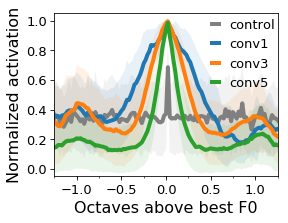

In [214]:
num_colors = 10#len(condition_dict.keys())
cmap_name = 'tab10'
COLOR_LIST = util_psychophysics_figures.get_color_list(num_colors, cmap_name=cmap_name)

color_condition_list = [
    ([0.5]*3, 'control'),
#     (0, 'relu_1_shuffle_F0'),
    (0, 'conv1'),
#     (0, 'relu_3_shuffle_F0'),
    (1, 'conv3'),
    (2, 'conv5'),
]

figsize=(4,3)
fontsize_labels=16
fontsize_legend=13
fontsize_ticks=13

xlimits=[-1.25, 1.25]
ylimits=[-0.05, 1.05]


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

for (cidx, key) in color_condition_list:
    rd = results_dicts[key]
    xval = rd['oct_array_mean_bins']
    yval = rd['oct_array_mean']
    yerr = rd['oct_array_err']
    
    if isinstance(cidx, int): color = COLOR_LIST[cidx]
    else: color = cidx
    
#     plot_kwargs = {
#         'lw': 0.1,
#         'color': color,
#         'label': None,
#     }
#     if 'control' not in key:
#         N = rd['oct_array'].shape[1]
#         for itr1 in range(N):
#             tuning_curve = rd['oct_array'][:, itr1]
#             octave_bins = rd['oct_bins']
#             valid_idx = tuning_curve >= 0
#             y = tuning_curve[valid_idx]
#             x = octave_bins[valid_idx]
#             ax.plot(x, y, **plot_kwargs)
    
    plot_kwargs = {
        'lw': 4,
        'color': color,
        'label': key,
    }
    
    ax.fill_between(xval, yval-yerr, yval+yerr,
                    alpha=0.10,
                    facecolor=plot_kwargs.get('color', 'k'))
    ax.plot(xval, yval, **plot_kwargs)
    
legend_plot_kwargs = {
    'loc':'upper right',
    'frameon':False,
    'fontsize':fontsize_legend,
    'handlelength': 0.5,
    'bbox_to_anchor': [1.04, 1.04],
}
ax.legend(**legend_plot_kwargs)

ax.set_xlabel('Octaves above best F0', fontsize=fontsize_labels)
ax.set_ylabel('Normalized activation', fontsize=fontsize_labels)


ax.set_xticks(np.arange(-1, 1.01, 0.5), minor=False)
ax.set_xticks(np.arange(xlimits[0], xlimits[1]+0.01, 0.25), minor=True)
# ax.set_yticks(np.arange(0, ylimits[-1]+0.1, yticks), minor=False)
# ax.set_yticks(np.arange(ylimits[0], ylimits[-1]+0.1, 0.1), minor=True)
ax.tick_params(axis='both', which='major', labelsize=fontsize_ticks, length=4)
ax.tick_params(axis='both', which='minor', length=2)
ax.set_xlim(xlimits)
ax.set_ylim(ylimits)


plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/'
# save_fn = os.path.join(save_dir, 'neurophysiology_f0_tuning_relu1relu3relu5_stddev.pdf')
# fig.savefig(save_fn, bbox_inches='tight')

In [206]:
def compute_centroids(output_dict,
                      key_act='relu_5',
                      kwargs_f0_bins={},
                      use_argmax=True):
    
    coarse_f0_bins = dataset_util.get_f0_bins(**kwargs_f0_bins)
    output_dict['f0_label_coarse'] = dataset_util.f0_to_label(output_dict['f0'],
                                                              coarse_f0_bins)
    tuning_tensor = compute_tuning_tensor(output_dict,
                                          key_act=key_act,
                                          key_x='low_harm',
                                          key_y='f0_label_coarse')
    
    f0_bin_values = np.array([coarse_f0_bins[idx]
                              for idx in np.unique(output_dict['f0_label_coarse'])])
    lh_bin_values = np.unique(output_dict['low_harm'])
    
    centroid_f0_list = []
    centroid_lh_list = []
    for itr2 in range(tuning_tensor.shape[2]):
        tuning_array = tuning_tensor[:, :, itr2]
        
        if use_argmax:
            ind = np.unravel_index(np.argmax(tuning_array, axis=None), tuning_array.shape)
            centroid_f0 = f0_bin_values[ind[1]]
            centroid_lh = lh_bin_values[ind[0]]
        else:
            weights_f0 = np.mean(tuning_array, axis=0)
            centroid_f0 = np.sum(weights_f0 * f0_bin_values) / np.sum(weights_f0)

            weights_lh = np.mean(tuning_array, axis=1)
            centroid_lh = np.sum(weights_lh * lh_bin_values) / np.sum(weights_lh)
            
        centroid_f0_list.append(centroid_f0)
        centroid_lh_list.append(centroid_lh)
    
    centroid_f0_list = np.array(centroid_f0_list)
    centroid_lh_list = np.array(centroid_lh_list)
    return centroid_f0_list, centroid_lh_list, f0_bin_values, lh_bin_values


kwargs_f0_bins = {'f0_min':80., 'f0_max':1e3, 'binwidth_in_octaves':1/(12*4)}
condition_list = ['relu_1', 'relu_2', 'relu_3', 'relu_4', 'relu_5']
results_dicts = {}
for key in condition_list:
    
    centroid_f0_list, centroid_lh_list, f0_bin_values, lh_bin_values = compute_centroids(
        output_dict, key_act=key, kwargs_f0_bins=kwargs_f0_bins)
    
    results_dicts[key] = {
        'f0_bin_values': f0_bin_values,
        'lh_bin_values': lh_bin_values,
        'centroid_f0_list': centroid_f0_list,
        'centroid_lh_list': centroid_lh_list,
        'centroid_f0_indexes': np.digitize(centroid_f0_list, f0_bin_values, right=True),
        'centroid_lh_indexes': np.digitize(centroid_lh_list, lh_bin_values, right=True),
    }

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/neurophysiology_scatterplot_tuning_peaks_relu_1.pdf
/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/neurophysiology_scatterplot_tuning_peaks_relu_3.pdf
/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/neurophysiology_scatterplot_tuning_peaks_relu_5.pdf


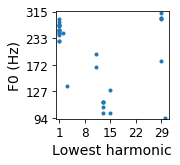

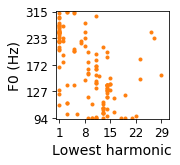

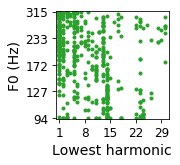

In [209]:
num_colors = 10#len(condition_dict.keys())
cmap_name = 'tab10'
COLOR_LIST = util_psychophysics_figures.get_color_list(num_colors, cmap_name=cmap_name)

color_condition_list = [
    (0, 'relu_1'),
    (1, 'relu_3'),
    (2, 'relu_5'),
]

figsize=(2.6, 2.4)
fontsize_labels=14
fontsize_legend=13
fontsize_ticks=12

for (cidx, key) in color_condition_list:
    rd = results_dicts[key]
    xidx = rd['centroid_lh_indexes']
    yidx = rd['centroid_f0_indexes']
    xbin = rd['lh_bin_values']
    ybin = rd['f0_bin_values']
    
    plot_kwargs = {
        'color': COLOR_LIST[cidx],
        'marker': '.',
        'ms': 6,
        'ls': '',
    }

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    ax.plot(xidx, yidx, **plot_kwargs)
    
    ax.set_xlabel('Lowest harmonic', fontsize=fontsize_labels)
    ax.set_ylabel('F0 (Hz)', fontsize=fontsize_labels)
    
    lh_idx = np.linspace(0, xbin.shape[0]-2, num=5, dtype=int)
    lh_labels = ['{:.0f}'.format(xbin[idx]) for idx in lh_idx]
    ax.set_xticks(lh_idx)
    ax.set_xticklabels(lh_labels)
    
    f0_idx = np.linspace(0, ybin.shape[0]-1, num=5, dtype=int)
    f0_labels = ['{:.0f}'.format(ybin[idx]) for idx in f0_idx]
    ax.set_yticks(f0_idx)
    ax.set_yticklabels(f0_labels)
    
    ax.set_xlim([-1, len(xbin)])
    ax.set_ylim([-1, len(ybin)])
    
    ax.tick_params(axis='both', which='major', labelsize=fontsize_ticks, length=4)
    
    plt.tight_layout()
    
#     save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/'
#     save_fn = os.path.join(save_dir, 'neurophysiology_scatterplot_tuning_peaks_{}.pdf'.format(key))
#     print(save_fn)
#     fig.savefig(save_fn, bbox_inches='tight')


plt.show()



In [200]:
coarse_f0_bins = dataset_util.get_f0_bins(f0_min=80., f0_max=1e3, binwidth_in_octaves=1/(12*4))
output_dict['f0']
output_dict['f0_label_coarse'] = dataset_util.f0_to_label(output_dict['f0'], coarse_f0_bins)

tuning_tensor = compute_tuning_tensor(output_dict, key_act='relu_1')
print('computed tuning_tensor:', tuning_tensor.shape)

f0_tuning_array = np.mean(tuning_tensor, axis=0)
print('computed f0_tuning_array:', f0_tuning_array.shape)

low_harm_tuning_array = np.mean(tuning_tensor, axis=1)
print('computed low_harm_tuning_array:', low_harm_tuning_array.shape)

sort_idx_f0_tuning = np.argsort(np.argmax(f0_tuning_array, axis=0))
sort_idx_low_harm_tuning = np.argsort(np.argmax(low_harm_tuning_array, axis=0))


tuning_tensor = tuning_tensor[:, :, sort_idx_low_harm_tuning]
f0_tuning_array = f0_tuning_array[:, sort_idx_low_harm_tuning]
low_harm_tuning_array = low_harm_tuning_array[:, sort_idx_low_harm_tuning]

computed tuning_tensor: (30, 85, 32)
computed f0_tuning_array: (85, 32)
computed low_harm_tuning_array: (30, 32)


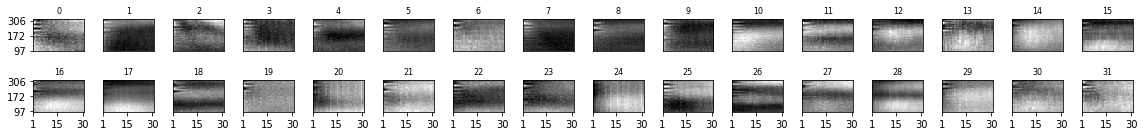

In [201]:
import matplotlib.cm


f0_bin_values = [coarse_f0_bins[idx] for idx in np.unique(output_dict['f0_label_coarse'])]
f0_bin_values = np.array(f0_bin_values)
f0_idx = np.linspace(2, f0_bin_values.shape[0]-3, num=3, dtype=int)
f0_labels = ['{:.0f}'.format(f0_bin_values[idx]) for idx in f0_idx]

low_harm_values = np.unique(output_dict['low_harm'])
low_harm_idx = np.linspace(0, low_harm_values.shape[0]-1, num=3, dtype=int)
low_harm_labels = ['{:.0f}'.format(low_harm_values[idx]) for idx in low_harm_idx]

N = tuning_tensor.shape[-1]

NCOLS = 16
NROWS = int(np.ceil(N / NCOLS))
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(1.0*NCOLS, 1.0*NROWS))
ax = ax.flatten()


for idx in range(N):
    Z = tuning_tensor[:, :, idx].T
    ax[idx].imshow(Z, origin='lower', aspect='auto', extent=[0, Z.shape[1], 0, Z.shape[0]],
                   cmap=matplotlib.cm.gray)
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    ax[idx].set_title(idx, fontsize=8)
    if idx % NCOLS == 0:
        ax[idx].set_yticks(f0_idx)
        ax[idx].set_yticklabels(f0_labels)
    if idx // NCOLS == NROWS - 1:
        ax[idx].set_xticks(low_harm_idx)
        ax[idx].set_xticklabels(low_harm_labels)

plt.tight_layout()
plt.show()

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/neurophysiology_relu1_unit010.pdf
/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/neurophysiology_relu1_unit022.pdf


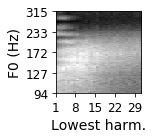

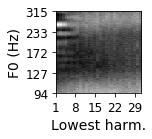

In [203]:
f0_bin_values = np.array([coarse_f0_bins[idx]
                          for idx in np.unique(output_dict['f0_label_coarse'])])
low_harm_values = np.unique(output_dict['low_harm'])

figsize=(2.6*0.85, 2.4*.85)
fontsize_labels=14
fontsize_legend=13
fontsize_ticks=12

idx_list = [10, 22] # Relu_1
# idx_list = [12, 99] # Relu_3
# idx_list = [340, 508] # Relu_5

for idx in idx_list:
    
    Z = tuning_tensor[:, :, idx].T
    xbin = low_harm_values
    ybin = f0_bin_values


    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    
    ax.imshow(Z, origin='lower', aspect='auto', extent=[0, Z.shape[1], 0, Z.shape[0]],
               cmap=matplotlib.cm.gray)
        
    ax.set_xlabel('Lowest harm.', fontsize=fontsize_labels)
    ax.set_ylabel('F0 (Hz)', fontsize=fontsize_labels)
    
    lh_idx = np.linspace(0, xbin.shape[0]-2, num=5, dtype=int)
    lh_labels = ['{:.0f}'.format(xbin[idx]) for idx in lh_idx]
    ax.set_xticks(lh_idx)
    ax.set_xticklabels(lh_labels)
    
    f0_idx = np.linspace(0, ybin.shape[0]-1, num=5, dtype=int)
    f0_labels = ['{:.0f}'.format(ybin[idx]) for idx in f0_idx]
    ax.set_yticks(f0_idx)
    ax.set_yticklabels(f0_labels)
    
    ax.tick_params(axis='both', which='major', labelsize=fontsize_ticks, length=4)
    
    plt.tight_layout()
    
#     save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/'
#     save_fn = os.path.join(save_dir, 'neurophysiology_relu1_unit{:03d}.pdf'.format(idx))
#     print(save_fn)
#     fig.savefig(save_fn, bbox_inches='tight')

plt.show()

